In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

In [4]:
drugbank_input = Chem.SDMolSupplier('../data/drugbank.sdf')
drugbank = [m for m in drugbank_input if m]
len(drugbank)

7110

# Substructure key

In [10]:
patterns = {
    'COO' : Chem.MolFromSmarts('C(=O)O'),
    'benzene' : Chem.MolFromSmarts('c1ccccc1'),
    'n': Chem.MolFromSmarts('[#7]'), # alternative: '[N,n]' (regex)
    'halogen' : Chem.MolFromSmarts('[F,Cl,Br,I]'),
    'tripple_bond' : Chem.MolFromSmarts('*#*'),
    'aliphatic_c' : Chem.MolFromSmarts('C'),
    's' : Chem.MolFromSmarts('[#16]')
}

order = ('COO', 'benzene', 'n', 'halogen', 'tripple_bond', 'aliphatic_c', 's')

def customkey(mol):
    return tuple((mol.HasSubstructMatch(patterns[pattern]) for pattern in order))

In [11]:
customkey(drugbank[666])

(True, True, True, False, False, True, False)

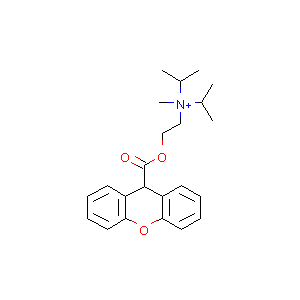

In [12]:
Draw.MolToImage(drugbank[666])

In [13]:
drugbank_awesome_fps = [customkey(mol) for mol in drugbank]
len(drugbank_awesome_fps)

7110

In [14]:
has_everything = [m for m, fp in zip(drugbank, drugbank_awesome_fps) if all(fp)]

In [15]:
len(has_everything)

3

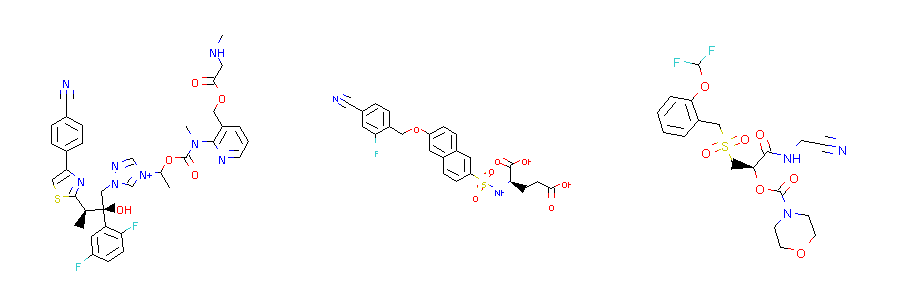

In [16]:
Draw.MolsToGridImage(has_everything, subImgSize = (300,300))

In [17]:
from rdkit.Chem import MACCSkeys

In [24]:
key = MACCSkeys.GenMACCSKeys(drugbank[666])
key.ToBitString()

'00000000000000000000000000000010000000000000000001000000010000000000000000100000000001100000010100101100010011011101101000110110000010000110010011111100111111111111110'

In [27]:
drugbank_maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in drugbank]

# Similarity

In [32]:
def tanimoto_similarity(fp1, fp2):
    fp1_on_bits = set((i for i, bit in enumerate(fp1) if bit))
    fp2_on_bits = set((i for i, bit in enumerate(fp2) if bit))
    all_bits = fp1_on_bits.union(fp2_on_bits)
    shared_bits = fp1_on_bits.intersection(fp2_on_bits)
    if not all_bits:
        return None
    return len(shared_bits) / len(all_bits)    

In [33]:
tanimoto_similarity((True, True, False, False), (True, True, False, False))

1.0

In [34]:
tanimoto_similarity((True, True, False, False), (False, False, False, False))

0.0

In [36]:
tanimoto_similarity((True, True, False, False), (False, True, True, True))

0.25

In [37]:
salicylica = Chem.MolFromSmiles('c1ccc(c(c1)C(=O)O)O')
salicylica_key = customkey(salicylica)
salicylica_key

(True, True, False, False, False, True, False)

In [38]:
salicylica_similarities = [tanimoto_similarity(salicylica_key, fp)
                          for fp in drugbank_awesome_fps]

In [39]:
salicylica_similarities[666]

0.75

In [40]:
drugbank_awesome_fps[666]

(True, True, True, False, False, True, False)

In [41]:
complete_hits = [i for i, similarity in enumerate(salicylica_similarities) if similarity == 1]
len(complete_hits)

148

In [46]:
salicylica_maccs = MACCSkeys.GenMACCSKeys(salicylica)
salicylica_maccs

In [47]:
from rdkit import DataStructs
salicylica_macs_similarities = [DataStructs.FingerprintSimilarity(salicylica_maccs, fp)
                               for fp in drugbank_maccs]

In [48]:
good_matches = [i for i, similarity in enumerate(salicylica_macs_similarities)
               if similarity ==1]
good_matches

[815]

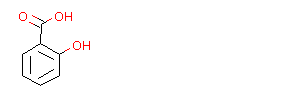

In [51]:
Draw.MolsToGridImage([drugbank[i] for i in good_matches], subImgSize=(100,100))

In [52]:
good_matches = [i for i, similarity in enumerate(salicylica_macs_similarities)
               if similarity >= 0.8]
good_matches

[815, 1433, 1454, 1482, 2503, 4151]

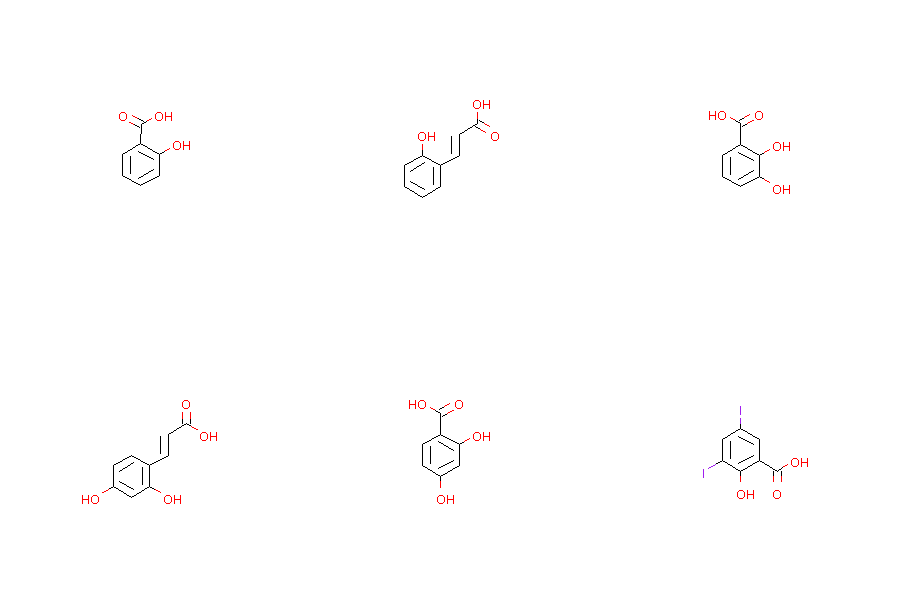

In [54]:
Draw.MolsToGridImage([drugbank[i] for i in good_matches], subImgSize=(300,300))